In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import libs

In [2]:
# Set global theme settings for plotting
plt.rcParams.update({
    'font.size': 20,          # Set font size
    'lines.linewidth': 3,     # Set default line thickness
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # Axis label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'grid.color': 'gray',     # Grid color
    'grid.linestyle': '--',   # Grid line style
    'grid.linewidth': 0.5,    # Grid line width
    'legend.fontsize': 16     # Legend font size
})

colorslist = ['#1f77b4', '#ff7f0e', '#2ca02c']

In [3]:
Uds = np.array([0.1, 2.0, 5.0])
PopulationSize = [100, 1000, 10000]
human_popsize = 10000
sd = -10**(-np.linspace(1, 2.5, 10))
iterations = 1000

Kimetalsd = -0.009
Boykoetalsd = -0.029

#x is the number of segregating mutations per individual
xmean = -Uds[1]/sd
Kim_xmean = -Uds/Kimetalsd
Boyko_xmean = -Uds/Boykoetalsd


negative_Eepsilon = -np.linspace(0.00001, 0.01, 100)
positive_Eepsilon = np.linspace(0.00001, 0.01, 100)

Kim_xmean[0]



np.float64(11.111111111111112)

In [4]:
#Make a test of growth rate and selective deaths functions using Boyko et al sd and human Ud=2
expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = libs.get_expected_min_max_poisson_sample(Kim_xmean[1], human_popsize, iterations)
testepsilon = -0.001
print(expected_min_Kim)
print(libs.get_growht_rate(expected_min_Kim, Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

print(Kim_xmean[1])
print(libs.get_growht_rate(Kim_xmean[1], Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

print(expected_max_Kim)
print(libs.get_growht_rate(expected_max_Kim, Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

print(libs.get_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

167.251
0.08093019758923786
222.22222222222223
0.05813266237113272
282.013
-12.36676996102587
0.0777419349658498


In [5]:
# Generate samples of min and max invidviduals with varying population sizes
expected_min_N0, std_error_min_N0, expected_max_N0, std_error_max_N0 = libs.vget_expected_min_max_poisson_sample(xmean, PopulationSize[0], iterations)
expected_min_N1, std_error_min_N1, expected_max_N1, std_error_max_N1 = libs.vget_expected_min_max_poisson_sample(xmean, PopulationSize[1], iterations)
expected_min_N2, std_error_min_N2, expected_max_N2, std_error_max_N2 = libs.vget_expected_min_max_poisson_sample(xmean, PopulationSize[2], iterations)

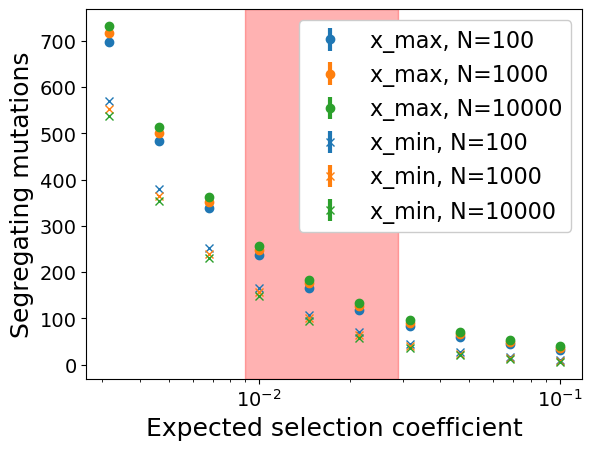

In [6]:
N_sizes = [str(PopulationSize[0]), str(PopulationSize[1]), str(PopulationSize[2])]

data_segregating = {
    (str(PopulationSize[0]), 'x_max'): (expected_max_N0, std_error_max_N0),
    (str(PopulationSize[1]), 'x_max'): (expected_max_N1, std_error_max_N1),
    (str(PopulationSize[2]), 'x_max'): (expected_max_N2, std_error_max_N2),
    (str(PopulationSize[0]), 'x_min'): (expected_min_N0, std_error_min_N0),
    (str(PopulationSize[1]), 'x_min'): (expected_min_N1, std_error_min_N1),
    (str(PopulationSize[2]), 'x_min'): (expected_min_N2, std_error_min_N2),
}

color_map = {str(PopulationSize[0]): '#1f77b4', str(PopulationSize[1]): '#ff7f0e', str(PopulationSize[2]): '#2ca02c'}
marker_map = {'x_max': 'o', 'x_min': 'x'}


for (N, value_type), (y, yerr) in data_segregating.items():
    plt.errorbar(-sd, y, yerr=yerr, fmt=marker_map[value_type], color=color_map[N], label=f'{value_type}, N={N}')

plt.xscale('log')
plt.xlabel('Expected selection coefficient')
plt.ylabel('Segregating mutations')
plt.axvspan(-Kimetalsd, -Boykoetalsd, color='r', alpha=0.3)
plt.legend(framealpha=1)
plt.savefig('graphs/Expectedminxmaxx.png', bbox_inches='tight') 

In [7]:
expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = libs.get_expected_min_max_poisson_sample(Kim_xmean[0], human_popsize, iterations)

mult_selective_deaths_Ud0 = libs.get_selective_deaths(Kim_xmean[0], expected_min_Kim, expected_max_Kim, Kimetalsd, 0.0)
negative_epistais_selective_deaths_Ud0 = libs.vget_selective_deaths(Kim_xmean[0], expected_min_Kim, expected_max_Kim, Kimetalsd, negative_Eepsilon)
positive_epistais_selective_deaths_Ud0 = libs.vget_selective_deaths(Kim_xmean[0], expected_min_Kim, expected_max_Kim, Kimetalsd, positive_Eepsilon)


expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = libs.get_expected_min_max_poisson_sample(Kim_xmean[1], human_popsize, iterations)

mult_selective_deaths_Ud1 = libs.get_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, 0.0)
negative_epistais_selective_deaths_Ud1 = libs.vget_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, negative_Eepsilon)
positive_epistais_selective_deaths_Ud1 = libs.vget_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, positive_Eepsilon)

expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = libs.get_expected_min_max_poisson_sample(Kim_xmean[2], human_popsize, iterations)

mult_selective_deaths_Ud2 = libs.get_selective_deaths(Kim_xmean[2], expected_min_Kim, expected_max_Kim, Kimetalsd, 0.0)
negative_epistais_selective_deaths_Ud2 = libs.vget_selective_deaths(Kim_xmean[2], expected_min_Kim, expected_max_Kim, Kimetalsd, negative_Eepsilon)
positive_epistais_selective_deaths_Ud2 = libs.vget_selective_deaths(Kim_xmean[2], expected_min_Kim, expected_max_Kim, Kimetalsd, positive_Eepsilon)

/home/uliseshmc/Documents/Proyectos/HighUd_populationgenetics/HighUd_Epistasis_Lead/libs.py:56: RuntimeWarning: invalid value encountered in scalar power
  genotype_term = (1.0+(E_epsilon/E_selectioncoeff))**(segregating_mutations)
/home/uliseshmc/Documents/Proyectos/HighUd_populationgenetics/HighUd_Epistasis_Lead/libs.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  rbest = -((E_selectioncoeff**2)/E_epsilon)*(expected_term-genotype_term)/(expected_term)
/home/uliseshmc/Documents/Proyectos/HighUd_populationgenetics/HighUd_Epistasis_Lead/libs.py:57: RuntimeWarning: invalid value encountered in scalar divide
  rbest = -((E_selectioncoeff**2)/E_epsilon)*(expected_term-genotype_term)/(expected_term)
/home/uliseshmc/Documents/Proyectos/HighUd_populationgenetics/HighUd_Epistasis_Lead/libs.py:63: RuntimeWarning: overflow encountered in exp
  fitness_best = np.exp(get_growht_rate(minsegregating, meansegregating, minsegregating, maxsegregating, E_selectioncoeff, E_epsilon))


/tmp/ipykernel_23735/987406836.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)


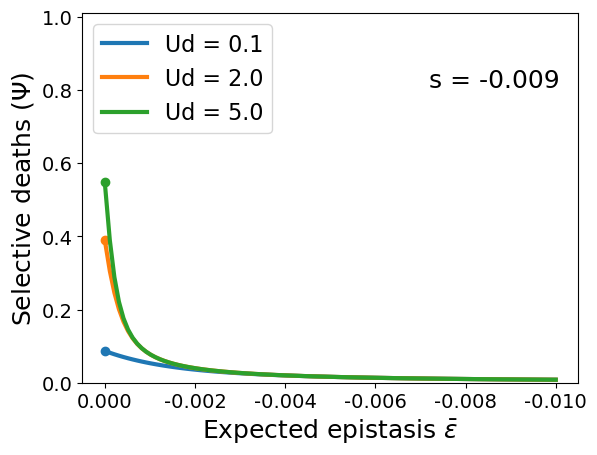

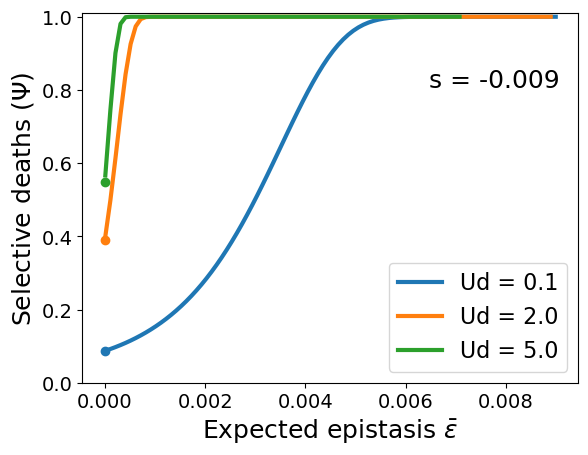

In [8]:
x_locator = FixedLocator([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
x_formatter = FixedFormatter(['0.000', '-0.002', '-0.004', '-0.006', '-0.008', '-0.010'])

fig = plt.figure()
ax = fig.gca()
ax.plot(-negative_Eepsilon, negative_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(-negative_Eepsilon, negative_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(-negative_Eepsilon, negative_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Expected epistasis ' + r'$\bar{\epsilon}$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Kimetalsd), fontsize=18, transform=ax.transAxes)
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
fig.savefig('graphs/Selectivedeaths_Kimnegativeepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)


fig = plt.figure()
ax = fig.gca()
ax.plot(positive_Eepsilon, positive_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(positive_Eepsilon, positive_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(positive_Eepsilon, positive_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Expected epistasis ' + r'$\bar{\epsilon}$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Kimetalsd), fontsize=18, transform=ax.transAxes)
fig.savefig('graphs/Selectivedeaths_Kimpositiveepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)


In [9]:
expected_min_Boyko, std_error_min_Boyko, expected_max_Boyko, std_error_max_Boyko = libs.get_expected_min_max_poisson_sample(Boyko_xmean[0], human_popsize, iterations)

mult_selective_deaths_Ud0 = libs.get_selective_deaths(Boyko_xmean[0], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, 0.0)
negative_epistais_selective_deaths_Ud0 = libs.vget_selective_deaths(Boyko_xmean[0], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, negative_Eepsilon)
positive_epistais_selective_deaths_Ud0 = libs.vget_selective_deaths(Boyko_xmean[0], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, positive_Eepsilon)


expected_min_Boyko, std_error_min_Boyko, expected_max_Boyko, std_error_max_Boyko = libs.get_expected_min_max_poisson_sample(Boyko_xmean[1], human_popsize, iterations)

mult_selective_deaths_Ud1 = libs.get_selective_deaths(Boyko_xmean[1], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, 0.0)
negative_epistais_selective_deaths_Ud1 = libs.vget_selective_deaths(Boyko_xmean[1], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, negative_Eepsilon)
positive_epistais_selective_deaths_Ud1 = libs.vget_selective_deaths(Boyko_xmean[1], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, positive_Eepsilon)

expected_min_Boyko, std_error_min_Boyko, expected_max_Boyko, std_error_max_Boyko = libs.get_expected_min_max_poisson_sample(Boyko_xmean[2], human_popsize, iterations)

mult_selective_deaths_Ud2 = libs.get_selective_deaths(Boyko_xmean[2], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, 0.0)
negative_epistais_selective_deaths_Ud2 = libs.vget_selective_deaths(Boyko_xmean[2], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, negative_Eepsilon)
positive_epistais_selective_deaths_Ud2 = libs.vget_selective_deaths(Boyko_xmean[2], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, positive_Eepsilon)

/tmp/ipykernel_23735/2909874616.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)


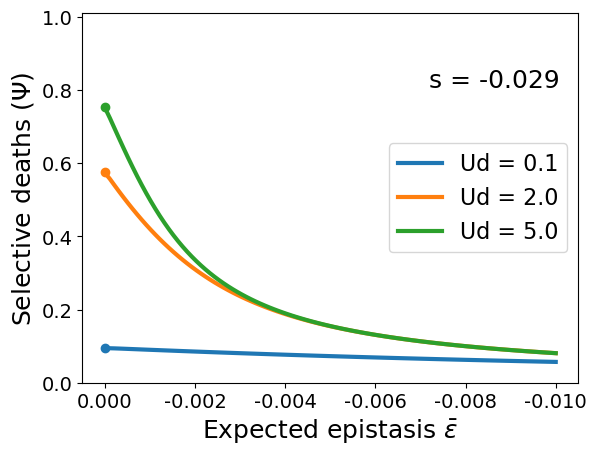

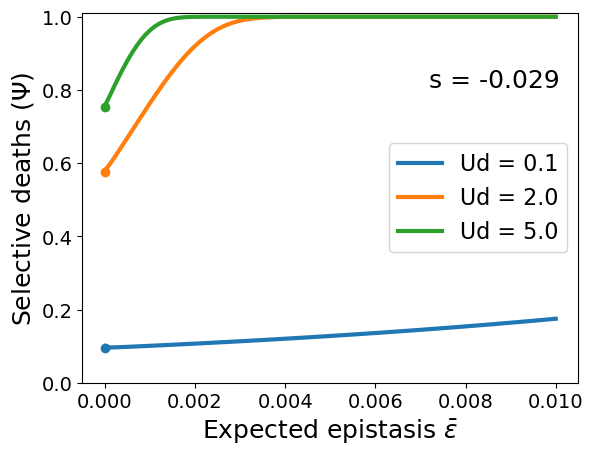

In [10]:
x_locator = FixedLocator([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
x_formatter = FixedFormatter(['0.000', '-0.002', '-0.004', '-0.006', '-0.008', '-0.010'])

fig = plt.figure()
ax = fig.gca()
ax.plot(-negative_Eepsilon, negative_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(-negative_Eepsilon, negative_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(-negative_Eepsilon, negative_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Expected epistasis ' + r'$\bar{\epsilon}$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Boykoetalsd), fontsize=18, transform=ax.transAxes)
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
fig.savefig('graphs/Selectivedeaths_Boykonegativeepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)


fig = plt.figure()
ax = fig.gca()
ax.plot(positive_Eepsilon, positive_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(positive_Eepsilon, positive_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(positive_Eepsilon, positive_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Expected epistasis ' + r'$\bar{\epsilon}$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Boykoetalsd), fontsize=18, transform=ax.transAxes)
fig.savefig('graphs/Selectivedeaths_Boykopositiveepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)